# 天池 — 工业蒸汽量预测

In [223]:
import numpy as np
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt
from matplotlib.font_manager import FontProperties
from sklearn.preprocessing import minmax_scale 
from mlxtend.preprocessing import minmax_scaling
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.preprocessing import scale
from sklearn.mixture import GaussianMixture
from sklearn.decomposition import PCA
from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import r2_score
import joblib
import xgboost as xgb
from xgboost.sklearn import XGBRegressor
from sklearn.metrics import mean_squared_error
from math import sqrt

## 读取数据

In [208]:
with open("D:/Jupyter Notebook/tianchi/zhengqi_train.txt") as fr:
    Data_all = pd.read_table(fr, sep="\t")
with open("D:/Jupyter Notebook/tianchi/zhengqi_test.txt") as fr_test:
    Data_test = pd.read_table(fr_test, sep="\t")

In [193]:
Data_all.describe()
#Data_all.corr()

,V0,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V29,V30,V31,V32,V33,V34,V35,V36,V37,target
count,2888.000000,2888.000000,2888.000000,2888.000000,2888.000000,2888.000000,2888.000000,2888.000000,2888.000000,2888.000000,...,2888.000000,2888.000000,2888.000000,2888.000000,2888.000000,2888.000000,2888.000000,2888.000000,2888.000000,2888.000000
mean,0.123048,0.056068,0.289720,-0.067790,0.012921,-0.558565,0.182892,0.116155,0.177856,-0.169452,...,0.097648,0.055477,0.127791,0.020806,0.007801,0.006715,0.197764,0.030658,-0.130330,0.126353
std,0.928031,0.941515,0.911236,0.970298,0.888377,0.517957,0.918054,0.955116,0.895444,0.953813,...,1.061200,0.901934,0.873028,0.902584,1.006995,1.003291,0.985675,0.970812,1.017196,0.983966
min,-4.335000,-5.122000,-3.420000,-3.956000,-4.742000,-2.182000,-4.576000,-5.048000,-4.692000,-12.891000,...,-2.912000,-4.507000,-5.859000,-4.053000,-4.627000,-4.789000,-5.695000,-2.608000,-3.630000,-3.044000
25%,-0.297000,-0.226250,-0.313000,-0.652250,-0.385000,-0.853000,-0.310000,-0.295000,-0.159000,-0.390000,...,-0.664000,-0.283000,-0.170250,-0.407250,-0.499000,-0.290000,-0.202500,-0.413000,-0.798250,-0.350250
50%,0.359000,0.272500,0.386000,-0.044500,0.110000,-0.466000,0.388000,0.344000,0.362000,0.042000,...,-0.023000,0.053500,0.299500,0.039000,-0.040000,0.160000,0.364000,0.137000,-0.185500,0.313000
75%,0.726000,0.599000,0.918250,0.624000,0.550250,-0.154000,0.831250,0.782250,0.726000,0.042000,...,0.745250,0.488000,0.635000,0.557000,0.462000,0.273000,0.602000,0.644250,0.495250,0.793250
max,2.121000,1.918000,2.828000,2.457000,2.689000,0.489000,1.895000,1.918000,2.245000,1.335000,...,4.580000,2.689000,2.013000,2.395000,5.465000,5.110000,2.324000,5.238000,3.000000,2.538000


## 去除异常值并归一化

In [209]:
# mixmax归一化
def MinMax(df):
    s_df = pd.DataFrame(columns=df.columns)
    for col in df.columns:
        s_value = minmax_scale(df[col])
        s_value = s_value.flatten()
        s_df[col] = s_value
    return s_df
# 去除3sigma以外的异常值
def RemoveOutlier(df):
    for col in df.columns:
        if (col=='label'):
            break
        df = df[abs(df[col]-df[col].mean())<=4.5*df[col].std()]
    return df

In [210]:
NOdata_all = RemoveOutlier(Data_all)
Sdata_all = MinMax(NOdata_all)
#Sdata_all = MinMax(Data_all)
Sdata_all.describe()

,V0,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V29,V30,V31,V32,V33,V34,V35,V36,V37,target
count,2771.000000,2771.000000,2771.000000,2771.000000,2771.000000,2771.000000,2771.000000,2771.000000,2771.000000,2771.000000,...,2771.000000,2771.000000,2771.000000,2771.000000,2771.000000,2771.000000,2771.000000,2771.000000,2771.000000,2771.000000
mean,0.694077,0.723465,0.528816,0.583415,0.604980,0.602670,0.725166,0.721821,0.665794,0.743384,...,0.386016,0.602806,0.682818,0.602530,0.492158,0.507026,0.693699,0.443490,0.525110,0.577973
std,0.136197,0.132583,0.165682,0.158881,0.125934,0.193386,0.146618,0.142052,0.138087,0.138826,...,0.141874,0.102227,0.136819,0.121499,0.101917,0.100533,0.131714,0.155623,0.148811,0.165756
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.630353,0.682181,0.422773,0.488095,0.545176,0.493074,0.643159,0.654392,0.609633,0.692184,...,0.282302,0.539862,0.631964,0.519378,0.442448,0.474278,0.652174,0.370067,0.428213,0.495163
50%,0.726228,0.750958,0.545284,0.588079,0.616305,0.636840,0.757027,0.754297,0.690846,0.769272,...,0.367917,0.590902,0.707531,0.595933,0.488849,0.521716,0.713073,0.460201,0.519641,0.606234
75%,0.781801,0.800337,0.643179,0.696054,0.682124,0.754212,0.829834,0.822110,0.750496,0.769272,...,0.473036,0.658434,0.764615,0.682569,0.539372,0.533629,0.747914,0.542977,0.618681,0.689896
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [211]:
Sdata_all.drop(["V5", "V9", "V17", 'V19', "V22", "V14", "V21", "V25", "V26", 'V27', 'V31', 'V32', "V33", "V34", 'V35'], inplace=True, axis=1)
Data_test.drop(["V5", "V9", "V17", 'V19', "V22", "V14", "V21", "V25", "V26", 'V27', 'V31', 'V32', "V33", "V34", 'V35'], inplace=True, axis=1)
#y_train = train_sdata["target"]
X_train = Sdata_all.drop("target", axis=1)
y_train = Sdata_all['target']

In [212]:
def Test_MinMax(df, max_value, min_value):
    s_df = pd.DataFrame(columns = df.columns)
    for col in df.columns:
        s_df[col] = (df[col]- min_value[col])/(max_value[col]- min_value[col])
    return s_df

In [213]:
max_value = NOdata_all.max()
min_value = NOdata_all.min()
X_test = Test_MinMax(Data_test, max_value, min_value)

## GMM聚类

In [214]:
def GMM_PCA(X):
    # GMM聚类数=3
    Model_GMM = GaussianMixture(n_components=2, covariance_type='full', random_state=0)
    Model_GMM.fit(X.values)
    labels = Model_GMM.predict(X.values)
    # PCA降至二维
    Model_PCA = PCA(n_components=2)
    X_PCA = Model_PCA.fit_transform(X)
    print(Model_PCA.explained_variance_ratio_)
    Data_PCA = pd.DataFrame({'x1':X_PCA[:,0],'x2':X_PCA[:,1],'label':labels})
    # 画聚类图
    fig = plt.figure(figsize=(20,5))
    index=np.arange(0, len(Data_PCA))

    plt.rcParams['font.sans-serif']=['SimHei']
    plt.rcParams['axes.unicode_minus']=False
    fig = plt.figure(figsize=(20,5))
    ax = fig.add_subplot(111)
    plt.scatter(index, Data_PCA['label'], s=0.2, c='mediumblue')
    plt.xlabel('样本点', fontsize=15)
    plt.ylabel('工况分类', fontsize=15)
    plt.show() 

    return [labels,Model_GMM]

[0.262447   0.23706208]


<Figure size 1440x360 with 0 Axes>

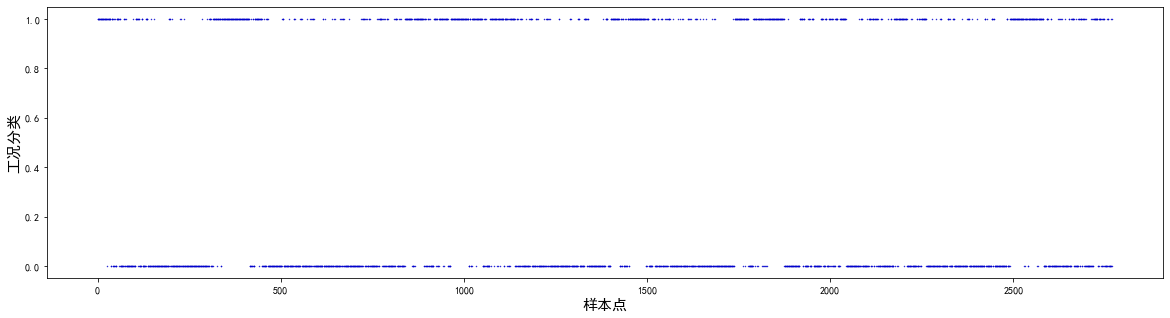

In [215]:
[labels,Model_GMM] = GMM_PCA(X_train)
Sdata_all['label'] = labels

## SVR预测

In [216]:
def CV_SVR(Data):
    n = len(Data)    
    train_len = int(n)
    X_train = Data.iloc[0:train_len, 0:23]
    y_train = Data.iloc[0:train_len,:]['target']
    #X_test = Data.iloc[train_len:n,0:13]
    #y_test = Data.iloc[train_len:n,:]['AI3012']
    Model = SVR()
    Model.fit(X_train,y_train)
    model = SVR()
    parameters = {'C':[0.1, 0.5, 1, 2, 10], 'gamma':[0.05, 0.06, 0.1, 'auto'], 'epsilon':[0.09, 0.1, 0.11]}
    reg = GridSearchCV(model,parameters)
    CV_result = reg.fit(X_train, y_train)
    Best_model = CV_result.best_estimator_
    Best_model.fit(X_train, y_train)
    #return [X_test, y_test, Best_model]
    return Best_model

In [217]:
Data_0 = Sdata_all[Sdata_all.label==0]
Data_1 = Sdata_all[Sdata_all.label==1]
#Data_2 = Sdata_all[Sdata_all.label==2]
#Data_3 = Sdata_all[Sdata_all.label==3]
#[X_test0, y_test0, Model_0] = CV_SVR(Data_0)
#[X_test1, y_test1, Model_1] = CV_SVR(Data_1)
#[X_test2, y_test2, Model_2] = CV_SVR(Data_2)
#[X_test3, y_test3, Model_3] = CV_SVR(Data_3)
Model_0 = CV_SVR(Data_0)
Model_1 = CV_SVR(Data_1)
#Model_2 = CV_SVR(Data_2)
#Model_3 = CV_SVR(Data_3)
model_SVR = [Model_0, Model_1]

C:\Users\T470s\Anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\T470s\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
C:\Users\T470s\Anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\T470s\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change

In [218]:
model_SVR

[SVR(C=10, cache_size=200, coef0=0.0, degree=3, epsilon=0.09, gamma='auto',
     kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False),
 SVR(C=0.5, cache_size=200, coef0=0.0, degree=3, epsilon=0.09, gamma=0.1,
     kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)]

## 测试集预测

In [220]:
y_test = np.zeros((len(X_test),1))
for i in range(len(X_test)):
    x_test = X_test.iloc[i:i+1,:]
    label = int(Model_GMM.predict(x_test.values))
    y_test[i] = model_SVR[label].predict(x_test)

y_max = Data_all['target'].max()
y_min = Data_all['target'].min()
#y_test_XGB = Model_XGB.predict(X_test)
#y_test1 = (ymax - ymin) * (0.5 * y_test_SVR + 0.5 * y_test_XGB) + ymin
y_test1 = (y_max - y_min) * (y_test) + y_min


In [221]:
y_test1.mean()
#NOdata_all['target'].mean()

-0.1282969255900244

In [222]:
pd.DataFrame(y_test1).to_csv('./Result.txt', index=False, header=False)